This notebook serves as an introduction to logistic regression. It follows a notebook on linear regression and machine learning written previously.

In [435]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import numpy as np

Logisitic Regression is often most valuable in classification problems. A common example is tumor diagnosis. There can be lots of input parameters (size of tumor, location of tumor, growth rate of tumor, etc), but often the thing you want to know is if the tumor is benign or malignant.

Let me use that as a good case example. I'll create some fake data right now, and then show how to use logistic regression and gradient descent to distinguish between the 2 cases.

First, I'll generate the fake tumor data I'll use for the rest of this notebook. There will be 2 measured parameters for each tumor: size and growth rate, with some overlap in each measure between benign and malignant.

In [452]:
df_tumor=pd.DataFrame(columns=['Size','Growth','label'])
n=60
df_tumor['Size']=np.concatenate((np.random.uniform(0.02, .55, size=n),np.random.uniform(.35, .98, size=n)))
df_tumor['Growth']=np.concatenate((np.random.uniform(0.02, .5, size=n),np.random.uniform(.35, .98, size=n)))
df_tumor.loc[0:n,'label']='Benign'
df_tumor.loc[n:,'label']='Malignant'

In [453]:
df_tumor.sample(10)

,Size,Growth,label
76,0.398116,0.770943,Malignant
66,0.481268,0.419521,Malignant
106,0.378159,0.723788,Malignant
37,0.221214,0.179972,Benign
42,0.032307,0.288306,Benign
15,0.038684,0.084633,Benign
112,0.845344,0.566309,Malignant
61,0.406644,0.865788,Malignant
107,0.495311,0.942131,Malignant
98,0.541748,0.938893,Malignant


Let me plot this for ease of viewing. I'll put the size of the tumor on the horizontal axis, growth on the vertical, and color code for benign or malignant:

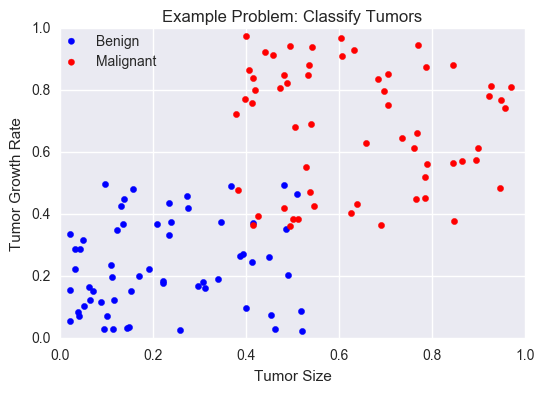

In [454]:
plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Growth'],label='Benign',color='Blue');
plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Growth'],label='Malignant',color='Red');
plt.legend(bbox_to_anchor=(.22, 1), loc=1, borderaxespad=0.)
plt.title('Example Problem: Classify Tumors');
plt.xlabel('Tumor Size');
plt.ylabel('Tumor Growth Rate');
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig('TrumorFakeExample.png',bbox_inches='tight')

(the way I made my fake data leads to the boxy like look of the two data sets. It's artificial, but then again, so is this example.)

Our end goal is to train a computer to develop a decision boundary to seperate these to types of tumors. With this data and in this dimension, it's easy for humans to determine the boundary by eye. But how should the computer decide what decision boundary to use? It needs some way of comparing decision boundary choices and picking the better one.

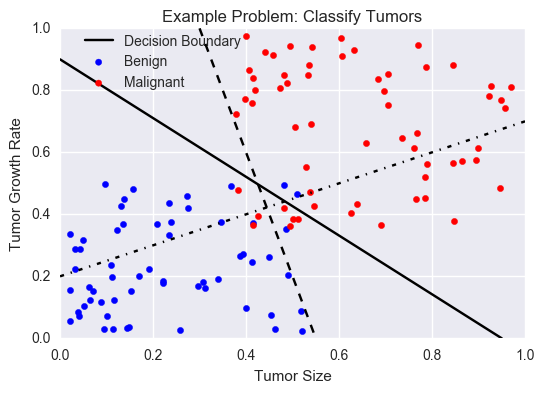

In [534]:
plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Growth'],label='Benign',color='Blue');
plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Growth'],label='Malignant',color='Red');
plt.plot([.3,.55],[1,0],color='black',linestyle='--');
plt.plot([0,1],[.2,.7],color='black',linestyle='-.');
plt.plot([0,.95],[.9,.0],color='black',linestyle='-',label='Decision Boundary');
plt.legend(bbox_to_anchor=(.4, 1), loc=1, borderaxespad=0.)
plt.title('Example Problem: Classify Tumors');
plt.xlabel('Tumor Size');
plt.ylabel('Tumor Growth Rate');
plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig('TrumorFakeExampleDB.png',bbox_inches='tight')

The computer will do this using logistic regression and gradient descent. To most easily show this, I'll only look at a single variable from above. Say, tumor size.

I'll also convert the numeric label of the cancer to a number. In its simplist form, logistic regression seperates sets with values of 0 and 1, so I'll use those for the benign and malignant labels:

In [457]:
df_tumor.loc[df_tumor['label']=='Benign','label_num']=0
df_tumor.loc[df_tumor['label']=='Malignant','label_num']=1

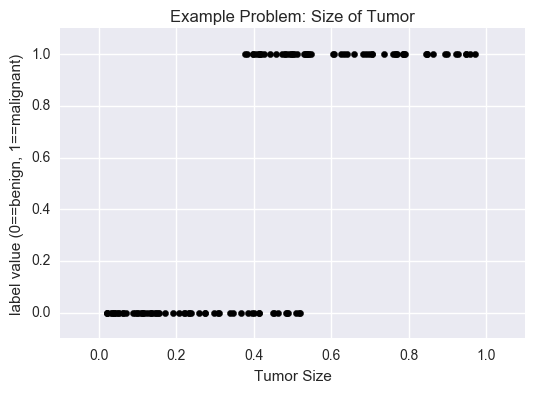

In [535]:
plt.scatter(df_tumor.loc[:,'Size'],df_tumor.loc[:,'label_num'],color='Black');
plt.title('Example Problem: Size of Tumor');
plt.xlabel('Tumor Size');
plt.ylabel('label value (0==benign, 1==malignant)');
plt.xlim([-.1,1.1]);
plt.ylim([-.1,1.1]);
plt.savefig('TumorSizePlot.png',bbox_inches='tight')

Now, I'll define the the sigmoid (the nonlinear math bit of logestic regression). X represents our inputs. In this case, the size of the tumor (and a constant term!). Theta represents weights for those inputs. The choice of Theta will affect where the decision boundary is drawn.

the value of g is limited between 0 and 1. For large, negative values of z, g approaches 0. For very, positive values of z, g approaches 1. If z is 0, g is equal to .5. We will use that .5 value to distinguish betweent the 2 cases.

I'll add in the constant term into my dataframe, so I don't forget it later on:

In [482]:
df_tumor['const']=1

In [479]:
def sigmoid(Theta,X):
    z=np.dot(Theta,X.transpose())
    g=1/(1+np.exp(-z));
    return g

I'll plot g to make this more clear:

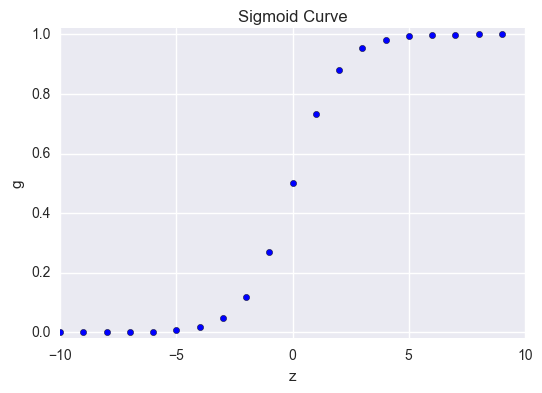

In [536]:
def lg(z):
    return 1/(1+np.exp(-z))
plt.scatter(list(range(-10,10)),lg(np.array(range(-10,10))))
plt.title('Sigmoid Curve');
plt.xlabel('z');
plt.ylabel('g');
plt.xlim([-10,10])
plt.ylim([-.02,1.02])
plt.savefig('SigmoidPlot.png',bbox_inches='tight')

I can choose some values for theta and apply the sigmoid function to my tumor Size data to see how it converts the distribution. Below I'll plot two different choices for theata, where the sigmoid has the same slope, but a different crossing point for the value of .5

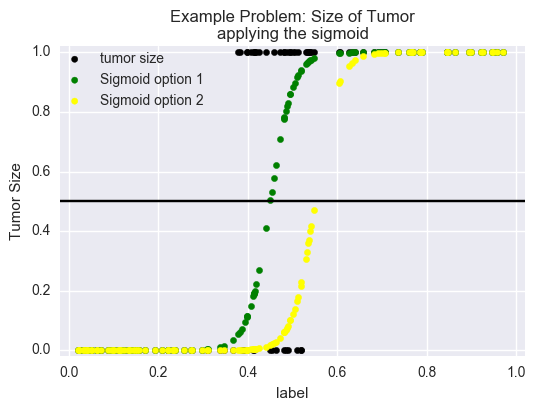

In [539]:
plt.scatter(df_tumor.loc[:,'Size'],df_tumor.loc[:,'label_num'],color='Black',label='tumor size');
l1=.45
plt.scatter(df_tumor.loc[:,'Size'].values,sigmoid([-40*l1,40],df_tumor.loc[:,['const','Size']].values),
            color='green',label='Sigmoid option 1')
l2=.55
plt.scatter(df_tumor.loc[:,'Size'].values,sigmoid([-40*l2,40],df_tumor.loc[:,['const','Size']].values),
            color='yellow',label='Sigmoid option 2')
plt.axhline(.5,color='black')
plt.legend(bbox_to_anchor=(.32, 1), loc=1, borderaxespad=0.)
plt.title('Example Problem: Size of Tumor\napplying the sigmoid');
plt.xlabel('label');
plt.ylabel('Tumor Size');
plt.xlim([-.02,1.02]);
plt.ylim([-.02,1.02]);
plt.savefig('TumorSizeSigmoidPlot.png',bbox_inches='tight')

So, how can the computer choose between these two curves? It needs a way of measuring how good the sigmoid does at correctly splitting the 2 groups. To do that, we'll use a cost function.

For given values in Theta, this cost function compares the labeled values of the training data (0 and 1) with the values given by the sigmoid. It then returns the sum of all the differences between the true and predicted values.

In [331]:
def CostFunction(y,Theta, X):
    J=-1/len(y)*(np.dot(y,np.log(sigmoid(Theta,X)+.005))+
                 np.dot(np.subtract(np.ones(len(y)),[0])-y,np.log(1.005-sigmoid(Theta,X))));
    return J

So for the 2 sigmoid options above, the cost function gives 2 different values:

In [495]:
CostFunction(df_tumor.loc[:,'label_num'],[-40*l1,40], df_tumor.loc[:,['const','Size']].values)

0.31648387825174851

In [496]:
CostFunction(df_tumor.loc[:,'label_num'],[-40*l2,40], df_tumor.loc[:,['const','Size']].values)

0.70167361955069163

Obviously, 1 is better than the other.

If we choose many values for a parameter of Theta and plot the cost function over all those values, there is a minimum cost at some value. That is our target for our computer to learn.

In [541]:
CF=[];
r=np.dot(list(range(0,20)),.05);
for l in r:
    CF.append(CostFunction(df_tumor.loc[:,'label_num'],[-40*l,40], df_tumor.loc[:,['const','Size']].values))

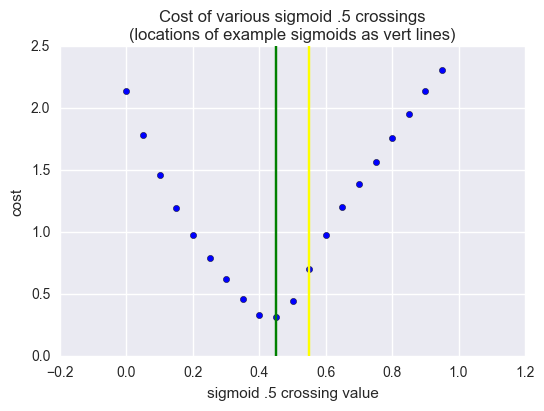

In [542]:
plt.scatter(r,CF);
plt.axvline(l1,color='green')
plt.axvline(l2,color='yellow')
plt.title('Cost of various sigmoid .5 crossings\n(locations of example sigmoids as vert lines)');
plt.xlabel('sigmoid .5 crossing value');
plt.ylabel('cost');
plt.savefig('GradientMinPlot.png',bbox_inches='tight')

The beauty of this is that there's a slope. And if there's a slope there's a gradient. And if there's a gradient, given any starting position, we can tell the computer which way to move to make sure it's going closer to the best choice each time.

Doing that, is called gradient descent. Given a starting point, we find the slope and take a step to reduce the cost function. Then we repeat over and over until we are near the minimum cost location.

In [558]:
Theta=np.random.rand(len(df_tumor.loc[0,['const','Size']]))
X=df_tumor.loc[:,['const','Size']]
y=df_tumor.loc[:,'label_num']
alpha=0.05;
CFs=[];
for x in range(0,500):
    Theta=Theta-alpha*np.dot(sigmoid(Theta,X)-y,X)
    j=CostFunction(y,Theta, X)
    CFs.append(j)
    #print(Theta)
#print(Theta)
print(CFs[-1])

0.243870182528


I can plot the cost function over time, and you can see it drops with each iteration of gradient descent.

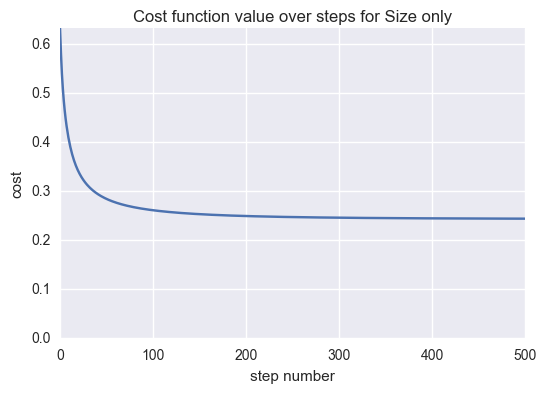

In [559]:
plt.plot(list(np.linspace(0,len(CFs),len(CFs))),CFs)
plt.title('Cost function value over steps for Size only');
plt.xlabel('step number');
plt.ylabel('cost');
plt.ylim([0,max(CFs)]);
plt.savefig('CostFunction_Size.png',bbox_inches='tight')

Finally, let me plot the optimum choice for theta for this single parameter of tumor size:

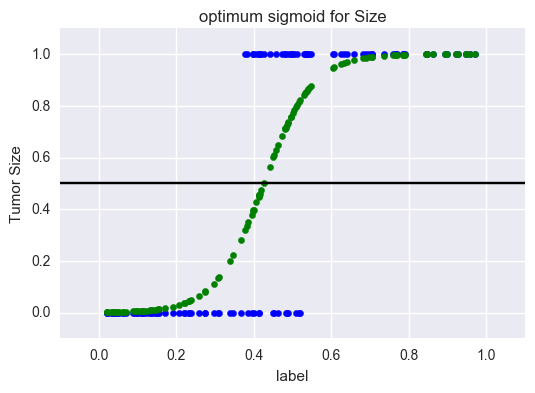

In [560]:
plt.scatter(df_tumor.loc[:,'Size'],df_tumor.loc[:,'label_num'],label='Size',color='Blue');

plt.scatter(df_tumor.loc[:,'Size'].values,sigmoid(Theta,df_tumor.loc[:,['const','Size']].values),color='green')
plt.axhline(.5,color='black')
plt.title('optimum sigmoid for Size');
plt.xlabel('label');
plt.ylabel('Tumor Size');
plt.xlim([-.1,1.1])
plt.ylim([-.1,1.1])
plt.savefig('TumorSizeSigmoidBestPlot.png',bbox_inches='tight')

Now, all of this training has been on a single variable of our data set: tumor size. Let me see how just looking at this dimension does on making a decision boundary:

In [561]:
df_tumor['score']=np.round(sigmoid(Theta,X))
acc=round(len(df_tumor.loc[df_tumor['label_num']==df_tumor['score'],:])/len(df_tumor),2);

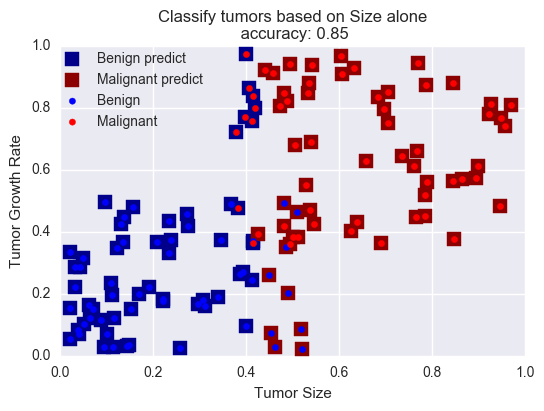

In [562]:
plt.scatter(df_tumor.loc[df_tumor.loc[:,'score']==0,'Size'],df_tumor.loc[df_tumor.loc[:,'score']==0,'Growth'],
            label='Benign predict',color='darkblue',s=100,marker='s');
plt.scatter(df_tumor.loc[df_tumor.loc[:,'score']==1,'Size'],df_tumor.loc[df_tumor.loc[:,'score']==1,'Growth'],
            label='Malignant predict',color='darkred',s=100,marker='s');

plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Growth'],label='Benign',color='Blue');
plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Growth'],label='Malignant',color='Red');
plt.legend(bbox_to_anchor=(.32, 1), loc=1, borderaxespad=0.)
plt.title('Classify tumors based on Size alone\n accuracy: %s'%(acc));
plt.xlabel('Tumor Size');
plt.ylabel('Tumor Growth Rate');
plt.xlim([0,1]);
plt.ylim([0,1]);
plt.savefig('PredictonSize.png',bbox_inches='tight')

Not bad, but let's see if this can be better by training on both variables Size and Growth:

In [563]:
Theta=np.random.rand(len(df_tumor.loc[0,['const','Size','Growth']]))
X=df_tumor.loc[:,['const','Size','Growth']]
y=df_tumor.loc[:,'label_num']
alpha=0.05;
CF=[];
for x in range(0,500):
    Theta=Theta-alpha*np.dot(sigmoid(Theta,X)-y,X)
    j=CostFunction(y,Theta, X)
    CF.append(j)
    #print(Theta)
#print(Theta)
print(CF[-1])

0.0971414673082


Already, notice that the cost value is less than it was with just 1 variable. That's a good sign!

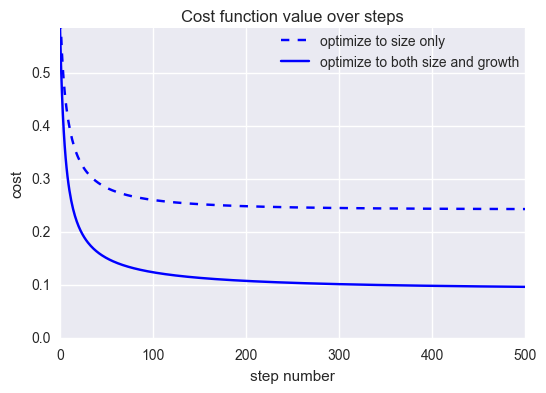

In [568]:
plt.plot(list(np.linspace(0,len(CFs),len(CFs))),CFs,color='blue',linestyle='--',label='optimize to size only')
plt.plot(list(np.linspace(0,len(CF),len(CF))),CF,color='blue',label='optimize to both size and growth')
plt.title('Cost function value over steps');
plt.xlabel('step number');
plt.ylabel('cost');
plt.ylim([0,max(CF)]);
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
plt.savefig('CostFunction_Both.png',bbox_inches='tight')

Before the big reveal, let me go back to looking just a the single variable Tumor and see how the new values of Theta compare with the old curve:

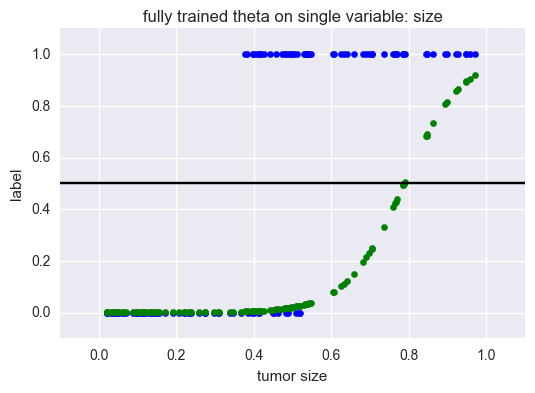

In [569]:
plt.scatter(df_tumor.loc[:,'Size'],df_tumor.loc[:,'label_num'],label='Size',color='Blue');

plt.scatter(df_tumor.loc[:,'Size'].values,sigmoid(Theta[0:2],df_tumor.loc[:,['const','Size']].values),color='green')
plt.axhline(.5,color='black')
#plt.legend(bbox_to_anchor=(.22, 1), loc=1, borderaxespad=0.)
plt.title('fully trained theta on single variable: size');
plt.xlabel('tumor size');
plt.ylabel('label');
plt.xlim([-.1,1.1]);
plt.ylim([-.1,1.1]);
plt.savefig('TumorSizeSigmoidBothPlot.png',bbox_inches='tight')

Note that this looks much worse! Same is true for growth:

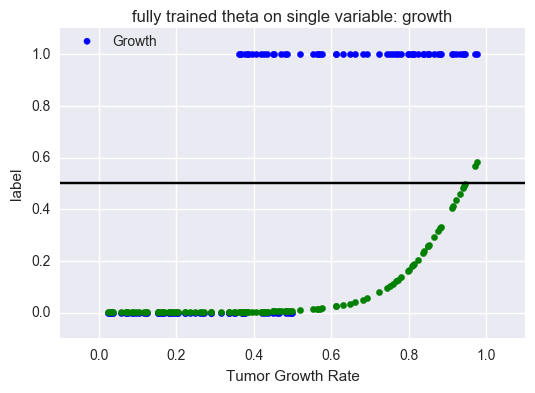

In [570]:
plt.scatter(df_tumor.loc[:,'Growth'],df_tumor.loc[:,'label_num'],label='Growth',color='Blue');

plt.scatter(df_tumor.loc[:,'Growth'].values,sigmoid(Theta[[0,2]],df_tumor.loc[:,['const','Growth']].values),color='green')
plt.axhline(.5,color='black')
plt.legend(bbox_to_anchor=(.22, 1), loc=1, borderaxespad=0.)
plt.title('fully trained theta on single variable: growth');
plt.xlabel('Tumor Growth Rate');
plt.ylabel('label');
plt.xlim([-.1,1.1])
plt.ylim([-.1,1.1])
plt.savefig('TumorGrowthSigmoidBothPlot.png',bbox_inches='tight')

But when we look at the the big picture, we can see the improvement.

In [572]:
df_tumor['score']=np.round(sigmoid(Theta,X))
acc=round(len(df_tumor.loc[df_tumor['label_num']==df_tumor['score'],:])/len(df_tumor),2);

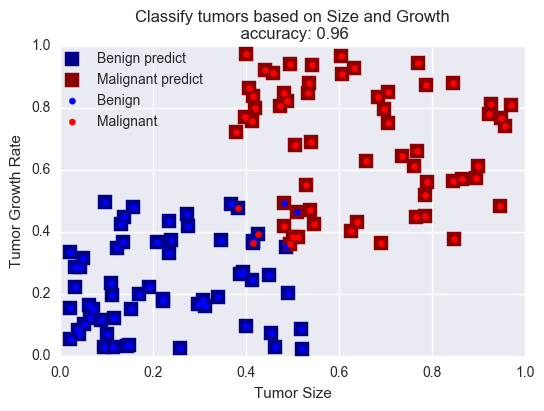

In [573]:
plt.scatter(df_tumor.loc[df_tumor.loc[:,'score']==0,'Size'],df_tumor.loc[df_tumor.loc[:,'score']==0,'Growth'],
            label='Benign predict',color='darkblue',s=100,marker='s');
plt.scatter(df_tumor.loc[df_tumor.loc[:,'score']==1,'Size'],df_tumor.loc[df_tumor.loc[:,'score']==1,'Growth'],
            label='Malignant predict',color='darkred',s=100,marker='s');

plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Benign','Growth'],label='Benign',color='Blue');
plt.scatter(df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Size'],df_tumor.loc[df_tumor.loc[:,'label']=='Malignant','Growth'],label='Malignant',color='Red');
plt.legend(bbox_to_anchor=(.32, 1), loc=1, borderaxespad=0.)
plt.title('Classify tumors based on Size and Growth\n accuracy: %s'%(acc));
plt.xlabel('Tumor Size');
plt.ylabel('Tumor Growth Rate');
plt.xlim([0,1]);
plt.ylim([0,1]);
plt.savefig('PredictonBoth.png',bbox_inches='tight')